# Footprint prediction output

In [1]:
import geopandas as gpd
import pandas as pd
import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import geoscilib

import matplotlib.pyplot as plt
import contextily as ctx
import re
import fiona
import math
import glob

/tmp/ipykernel_650312/2629257221.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import importlib
import footprintlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Landcover predictions

In [46]:
d = {
    'MAINDIR': '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/development',
    #RUNNAME = 'landcover_test_chm_std_global_focalloss' # 4-band + CHM + focal loss --> IGNORE THIS, it sucks - need to find better loss fun
    'RUNNAME': 'landcover_test_chm_std_local', #  4-band + CHM
    #RUNNAME = '...' # start with self-supervised pre-trained foundation model
    'OUTDIR': f'{MAINDIR}/{RUNNAME}/predictions',
    'TARGET': 'sr-02m.landcover.tif',
    'TARGET_DIR': f'{OUTDIR}/002m', # predictions dir,
    'TYPE_NAME': "$LC_{SR}$",
    'SPLIT_STR': '-sr'
}

print(f"Target dir to be footprinted:\n\t{d['TARGET_DIR']}")
# output footprints filename
OUT_FOOT_FN = os.path.join(d['MAINDIR'], 'footprints', f"footprints_{d['RUNNAME']}.gpkg")
print(f'Footprint will be here:\n\t{OUT_FOOT_FN}')

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/002m
Footprint will be here:
	/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/development/footprints/footprints_landcover_test_chm_std_local.gpkg


### CHM predictions

In [52]:
d = {
    'MAINDIR': '/explore/nobackup/projects/above/misc/ABoVE_Shrubs',
    'RUNNAME': '20231014_chm',
    'OUTDIR': f'{MAINDIR}/chm/{RUNNAME}',
    'TARGET': '-chm-dm-10m.tif',
    'TARGET_DIR': f'{OUTDIR}/dm_10m' ,    # predictions dir
    'TYPE_NAME': "$CHM_{SR}$",
    'SPLIT_STR': '-chm'
}

print(f"Target dir to be footprinted:\n\t{d['TARGET_DIR']}")
# output footprints filename
OUT_FOOT_FN = os.path.join(d['MAINDIR'], 'footprints', f"footprints_{d['RUNNAME']}.gpkg")
print(f'Footprint will be here:\n\t{OUT_FOOT_FN}')

Target dir to be footprinted:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m
Footprint will be here:
	/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_20231014_chm.gpkg


## Build list of predictions

In [53]:
# Get footprints gdf from a target dir
print(d['TARGET_DIR'])

# Get the list of filenames
SEARTH_STRING = f"/*{d['TARGET']}"

f_list = glob.glob(f"{d['TARGET_DIR']}{SEARTH_STRING}", recursive=True)
print(f'Search returned {len(f_list)}')


/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m
Search returned 946


In [54]:
f_list[0:4]

['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV03_20200704_M1BS_104001005CC4E300-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20140802_M1BS_10300100342CF900-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV03_20200703_M1BS_104001005D47BB00-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20190817_M1BS_1030010096CA3300-chm-dm-10m.tif']

# Footprint

In [55]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list)

CPU times: user 338 ms, sys: 354 ms, total: 691 ms
Wall time: 5.98 s


In [56]:
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf = footprintlib.get_attributes_from_filename(footprint_gdf, d['TYPE_NAME'], d['SPLIT_STR'])

footprint_gdf['year_cat'] = footprint_gdf.year.astype(str)
footprint_gdf['month_cat'] = footprint_gdf.month.astype(str)

footprint_gdf.to_file(OUT_FOOT_FN, driver='GPKG')

footprint_gdf.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 946 entries, 0 to 945
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            946 non-null    object        
 1   geometry        946 non-null    geometry      
 2   footprint_name  946 non-null    object        
 3   path            946 non-null    object        
 4   area_km2        946 non-null    float64       
 5   area_ha         946 non-null    float64       
 6   type            946 non-null    object        
 7   catid           946 non-null    object        
 8   sensor          946 non-null    object        
 9   year            946 non-null    int64         
 10  month           946 non-null    int64         
 11  date            946 non-null    datetime64[ns]
 12  year_cat        946 non-null    object        
 13  month_cat       946 non-null    object        
dtypes: datetime64[ns](1), fl

<Axes: >

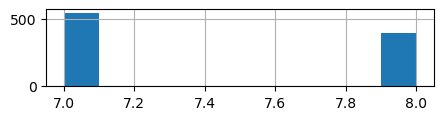

In [9]:
footprint_gdf.month_cat.hist(figsize=(5,1))

<Axes: >

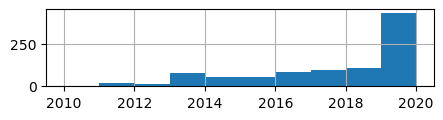

In [10]:
footprint_gdf.year_cat.hist(figsize=(5,1))

In [57]:
footprint_gdf.drop('date', axis=1).cx[-170:-120,40:75].explore(column='year_cat', cmap='magma',
                                                               style_kwds={'fillOpacity':0.5, 'color':'black', 'stroke':False}, 
                                                               legend=True, height=500
                                                              )

In [15]:
footprint_gdf.drop('date', axis=1)[(footprint_gdf.month == 7) | 
                                   (footprint_gdf.month == 8)].cx[-170:-120,40:75].explore(column='month_cat', cmap='inferno', 
                                                                                        style_kwds={'fillOpacity':0.5, 'stroke':False}, 
                                                                                        legend_kwds={'label': "Acquisition year", "location":'top', 'shrink': 0.5, 'orientation': "horizontal"},
                                                                                        #m=m
                                                                                          )